In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [75]:
class CosineScheduler:
    def __init__(self, t_0: float, t_f: float, s: float = 0.0):
        self.t_0 = t_0
        self.t_f = t_f
        self.s = s

    def lambda_t0(self, t):
        return 1 - np.cos(0.5 * np.pi * ((t / self.t_f) + self.s) / (1 + self.s)) ** 2

    def lambda_t(self, t1, t0):
        return 1 - np.exp(
            -np.abs(
                np.log(
                    np.cos(0.5 * np.pi * ((t1 / self.t_f) + self.s) / (1 + self.s))
                    ** 2
                )
                - np.log(
                    np.cos(0.5 * np.pi * ((t0 / self.t_f) + self.s) / (1 + self.s))
                    ** 2
                )
            )
        )

def cos_sq_fn_step_scheme(
    start, end, dt, s=0.008, dtype=np.float32, **_):
  """Exponential decay step scheme from Nichol and Dhariwal 2021.

  Args:
    start: start time defaults to 0
    end: end time defaults to 1
    dt: number of steps to divide grid into
    s: shift to ensure non 0
    dtype: for tpu support
    **_: placeholder to handle different scheme args

  Returns:
    time grid
  """
  n_steps = int((end - start) / dt)

  pre_phase = np.linspace(start, end, n_steps, dtype=dtype) / end
  phase = ((pre_phase + s) / (1 + s)) * np.pi * 0.5
  # Note this multiples small numbers however implemented it more stably
  # (removed sqrt from solver only sqrd here) and it made no difference to
  # results
  dts = np.cos(phase)**2

  dts /= dts.sum()
  dts *= end  # We normalise s.t. \sum_k \beta_k = T (where beta_k = b_m*cos^4)

  dts_out = np.concatenate((np.array([start]), np.cumsum(dts)))
  return dts_out

def cos_sq_fn_step_scheme_unnorm(
    start, end, dt, s=0.008, dtype=np.float32, **_):
  """Exponential decay step scheme from Nichol and Dhariwal 2021.

  Args:
    start: start time defaults to 0
    end: end time defaults to 1
    dt: number of steps to divide grid into
    s: shift to ensure non 0
    dtype: for tpu support
    **_: placeholder to handle different scheme args

  Returns:
    time grid
  """
  n_steps = int((end - start) / dt)

  pre_phase = np.linspace(start, end, n_steps, dtype=dtype) / end
  phase = ((1-pre_phase + s) / (1 + s)) * np.pi * 0.5
  # Note this multiples small numbers however implemented it more stably
  # (removed sqrt from solver only sqrd here) and it made no difference to
  # results
  dts = np.cos(phase)**2

  # dts /= dts.sum()
  # dts *= end  # We normalise s.t. \sum_k \beta_k = T (where beta_k = b_m*cos^4)

  dts_out = np.concatenate((np.array([start]), np.cumsum(dts)))
  return dts_out

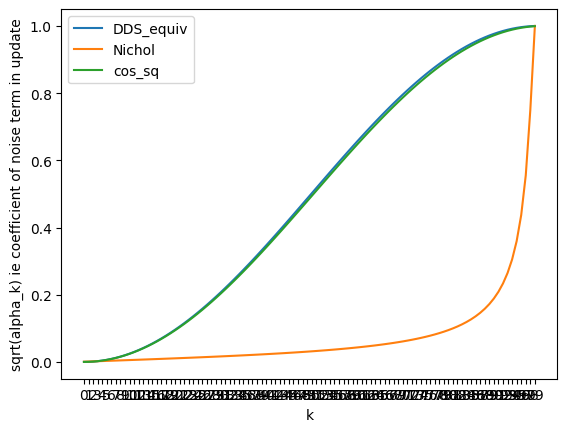

In [130]:
t0 = 0.0
t1 = 3.2
K=64
alpha = 1.075
alpha_mod = 1.0
dt = t1/K
s = 0.008

ts = cos_sq_fn_step_scheme(t0, t1, dt)
beta_k = np.clip(alpha * (ts[1:] - ts[:-1]), 0, 1)
# print(1 - np.prod(1-beta_k**2))

K=100
ts = cos_sq_fn_step_scheme_unnorm(0.0, 1.0, 1.0/K, s=s)
beta_k_equiv = np.clip(alpha_mod * (ts[1:] - ts[:-1]), 0, 1)
# print(1 - np.prod(1-beta_k_equiv**2))

cosine_schedule =  CosineScheduler(0.0, 1.0, s)
ts = np.linspace(0.0, 1.0, K+1)
beta_k_nichol = cosine_schedule.lambda_t(ts[:-1], ts[1:])
# print(1 - np.prod(1-beta_k_nichol**2))

ks = np.arange(0, K)
# plt.plot(ks, beta_k, label='DDS')
plt.plot(ks, (beta_k_equiv), label='DDS_equiv')
plt.plot(ks, (beta_k_nichol), label='Nichol')
plt.plot(ks, np.cos(np.pi * 0.5 * ((1-ks/(K))+s)/(1+s))**2, label='cos_sq')
plt.xticks(ks)
plt.legend()
plt.xlabel('k')
plt.ylabel('sqrt(alpha_k) ie coefficient of noise term in update')
plt.show()

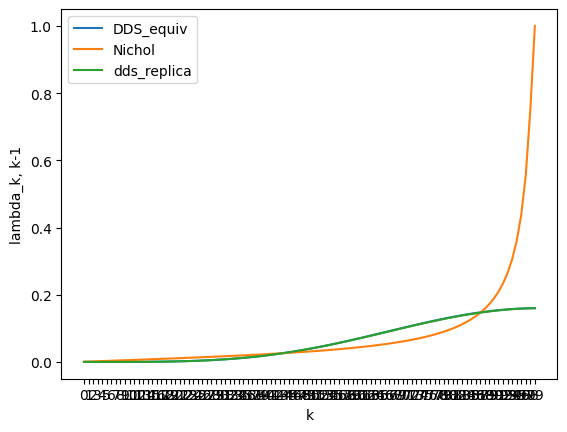

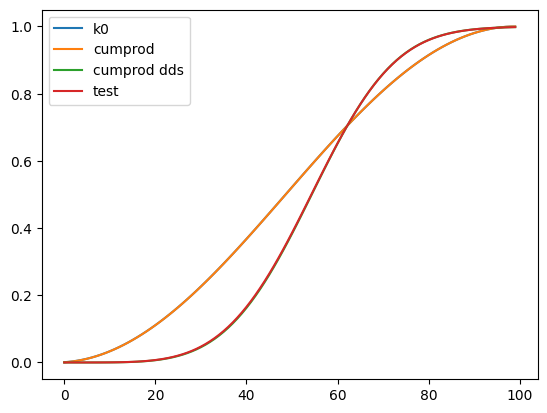

In [132]:
K=100
s=0.008
ts = cos_sq_fn_step_scheme_unnorm(0.0, 1.0, 1.0/K, s=s)
beta_k_equiv = np.clip(0.4 * (ts[1:] - ts[:-1]), 0, 1)**2

cosine_schedule =  CosineScheduler(0.0, 1.0, s)
ts = np.linspace(0.0, 1.0, K+1)
lambda_kk_1 = cosine_schedule.lambda_t(ts[:-1], ts[1:])
lambda_k0 = cosine_schedule.lambda_t0(ts[1:])

def lambda_t(t0, t1, tf, alpha_max, s):
    t = (t0+t1)/(2*tf)
    phase = ((1-t + s) / (1 + s)) * np.pi * 0.5
    return alpha_max **2 * np.cos(phase)**4


ks = np.arange(0, K)
# plt.plot(ks, beta_k, label='DDS')
plt.plot(ks, beta_k_equiv, label='DDS_equiv')
plt.plot(ks, lambda_kk_1, label='Nichol')
# plt.plot(ks[1:], np.cos(np.pi * 0.5 * ((1-(ks[1:])/(K))+s)/(1+s))**4, label='cos^4')
plt.plot(ks, lambda_t(ts[:-1], ts[1:], tf=1, alpha_max=0.4, s=s), label='dds_replica')
plt.xticks(ks)
plt.legend()
plt.xlabel('k')
plt.ylabel('lambda_k, k-1')
plt.show()

plt.figure()
plt.plot(ks, lambda_k0, label='k0')
plt.plot(ks, 1 - np.cumprod(1-lambda_kk_1), label='cumprod')
plt.plot(ks, 1 - np.cumprod(1-beta_k_equiv), label='cumprod dds')
plt.plot(ks, 1 - np.cumprod(1-lambda_t(ts[:-1], ts[1:], tf=1, alpha_max=0.4, s=s)), label='test')
plt.legend()
plt.show()

In [127]:
K = 100
tf=16.35243
t0=0.0
ts = np.linspace(t0, tf, K+1)
lambdas_0 = np.concatenate([np.array([0.0]), 1 - np.cumprod(1-lambda_t(ts[:-1], ts[1:], tf=tf, alpha_max=1, s=s))])
int(ts[0]*K/tf)

0